
# Trabalho 2 — Unidade 2 (A* + MST) — **Shoppings nas capitais do Nordeste**

Este notebook implementa o pipeline completo usando **A*** + **MST** sobre a malha viária real para **todas as capitais da Região Nordeste do Brasil**, considerando **todos os shoppings** (tag **`shop=mall`**) como POIs em cada cidade.


In [1]:

# Dependências
%pip -q install osmnx==1.9.3 networkx matplotlib pandas

import time
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox

# Configurações do OSMnx
ox.settings.log_console = False
ox.settings.use_cache = True

print("Versões -> osmnx:", ox.__version__, "| networkx:", nx.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.0 MB/s eta 0:00:00
Versões -> osmnx: 1.9.3 | networkx: 3.5



**Comentário do bloco acima:**  
Instala e importa as bibliotecas necessárias (**OSMnx**, **NetworkX**, **Pandas**, **Matplotlib**). Em seguida, configura o OSMnx para uso em cache e exibe as versões, garantindo reprodutibilidade.


In [2]:

def great_circle_heuristic(G, u, v):
    # Heurística admissível (great-circle) para A*: distância geodésica direta entre u e v
    return ox.distance.great_circle(G.nodes[u]['y'], G.nodes[u]['x'],
                                    G.nodes[v]['y'], G.nodes[v]['x'])

def astar_path_length_by_length(G, source, target):
    # Distância mínima por A* ponderada por 'length' entre source e target
    return nx.astar_path_length(
        G, source, target,
        heuristic=lambda a, b: great_circle_heuristic(G, a, b),
        weight='length'
    )



**Comentário do bloco acima:**  
Define a **heurística geodésica** (great-circle) para o A*, que é **admissível** (não superestima o custo). A função `astar_path_length_by_length` usa `networkx.astar_path_length` com peso `'length'`, retornando a distância mínima em **metros** na rede viária.


In [3]:

def build_city_graph(place: str, network_type: str = 'drive'):
    # Obtém o grafo viário, converte para não-direcionado e garante 'length' nas arestas
    G = ox.graph_from_place(place, network_type=network_type)
    G_undirected = ox.convert.to_undirected(G)
    G_undirected = ox.distance.add_edge_lengths(G_undirected)
    return G, G_undirected



**Comentário do bloco acima:**  
`build_city_graph` usa o **OpenStreetMap** para obter a malha viária da cidade, converte para **não-direcionado** (`convert.to_undirected`) e garante o atributo **`length`** em todas as arestas (`distance.add_edge_lengths`), necessário para calcular distâncias.


In [4]:

def get_all_mall_nodes(G_undirected, place: str):
    # Coleta *todos* os shoppings (OSM: shop=mall) em 'place' e mapeia cada POI para o nó mais próximo
    tags = {"shop": "mall"}
    gdf = ox.geometries_from_place(place, tags)
    if gdf.empty:
        return []
    candidate_points = []
    for _, row in gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        pt = geom if geom.geom_type == "Point" else geom.centroid
        candidate_points.append((pt.y, pt.x))  # (lat, lon)
    nodes = []
    for lat, lon in candidate_points:
        try:
            nid = ox.distance.nearest_nodes(G_undirected, lon, lat)  # (x=lon, y=lat)
            nodes.append(nid)
        except Exception:
            pass
    seen, unique_nodes = set(), []
    for n in nodes:
        if n not in seen:
            seen.add(n)
            unique_nodes.append(n)
    return unique_nodes



**Comentário do bloco acima:**  
`get_all_mall_nodes` busca **todos os POIs com `shop=mall`** na cidade, converte geometria para ponto (com **centroides** quando necessário) e mapeia cada POI ao **nó mais próximo** do grafo com `nearest_nodes`. Remove duplicados preservando a ordem.


In [5]:

def build_complete_graph_from_pois(G_undirected, poi_nodes):
    # Grafo completo entre os POIs; peso = menor rota (A*) em metros
    H = nx.Graph()
    H.add_nodes_from(poi_nodes)
    for i, u in enumerate(poi_nodes):
        for v in poi_nodes[i+1:]:
            try:
                d = astar_path_length_by_length(G_undirected, u, v)
            except Exception:
                d = nx.shortest_path_length(G_undirected, u, v, weight='length')
            H.add_edge(u, v, weight=float(d))
    return H



**Comentário do bloco acima:**  
`build_complete_graph_from_pois` monta o **grafo completo** entre os POIs, calculando o **menor caminho** entre cada par pelo A*. Em casos raros de falha, faz **fallback** para Dijkstra. Esse grafo é a base para o **cálculo da MST**.


In [6]:

def compute_mst_edges(complete_graph: nx.Graph):
    # MST do grafo completo (equivalente ao Kruskal do notebook de referência)
    return list(nx.minimum_spanning_edges(complete_graph, data=True))

def reconstruct_mst_routes_in_city(G_undirected, mst_edges):
    # Cada aresta (u, v) da MST é reconstruída como rota real no grafo viário
    routes = []
    for (u, v, d) in mst_edges:
        route = nx.shortest_path(G_undirected, u, v, weight='length')
        routes.append(route)
    return routes



**Comentário do bloco acima:**  
`compute_mst_edges` obtém a **Árvore Geradora Mínima (MST)** usando `minimum_spanning_edges`. `reconstruct_mst_routes_in_city` **mapeia cada aresta da MST** de volta para um **caminho real** na malha viária (menor caminho por `length`).


In [7]:

def plot_city_mst(G_undirected, poi_nodes, mst_routes, title="MST entre Shoppings (shop=mall)"):
    # Visualização da malha + POIs + rotas MST
    fig, ax = ox.plot_graph(G_undirected, node_size=0, edge_color="lightgray",
                            edge_linewidth=0.5, show=False, close=False)
    for route in mst_routes:
        xs = [G_undirected.nodes[n]['x'] for n in route]
        ys = [G_undirected.nodes[n]['y'] for n in route]
        ax.plot(xs, ys, linewidth=2.0, zorder=3)
    xs = [G_undirected.nodes[n]['x'] for n in poi_nodes]
    ys = [G_undirected.nodes[n]['y'] for n in poi_nodes]
    ax.scatter(xs, ys, s=60, c="black", zorder=4)
    ax.set_title(title)
    plt.show()



**Comentário do bloco acima:**  
`plot_city_mst` usa o **OSMnx** para desenhar a malha viária e sobrepõe: (i) as **rotas** da MST com linhas, e (ii) os **POIs** (shoppings) como pontos. O título identifica a cidade.


In [8]:

def run_city_pipeline(place: str, plot: bool = False):
    # Pipeline completo para uma cidade
    G, G_u = build_city_graph(place)
    poi_nodes = get_all_mall_nodes(G_u, place)
    if len(poi_nodes) < 2:
        return {"place": place, "n_pois": len(poi_nodes), "mst_total_length_m": float("nan"),
                "status": "POIs insuficientes", "poi_nodes": poi_nodes, "G_u": G_u, "G": G, "mst_routes": []}
    H = build_complete_graph_from_pois(G_u, poi_nodes)
    mst_edges = compute_mst_edges(H)
    total = float(sum(d['weight'] for (_,_,d) in mst_edges))
    routes = reconstruct_mst_routes_in_city(G_u, mst_edges)
    if plot:
        plot_city_mst(G_u, poi_nodes, routes, title=f"MST entre Shoppings em {place}")
    return {"place": place, "n_pois": len(poi_nodes), "mst_total_length_m": total,
            "status": "ok", "poi_nodes": poi_nodes, "G_u": G_u, "G": G, "mst_routes": routes}



**Comentário do bloco acima:**  
`run_city_pipeline` integra todas as etapas para **uma cidade**: constrói a malha, coleta **todos** os shoppings, cria o grafo completo por A*, obtém a **MST** e reconstrói as rotas reais. Pode **plotar** o resultado final quando `plot=True`.


In [9]:

# Todas as capitais do Nordeste (9)
cities = [
    "Salvador, Bahia, Brazil",
    "Aracaju, Sergipe, Brazil",
    "Maceió, Alagoas, Brazil",
    "Recife, Pernambuco, Brazil",
    "João Pessoa, Paraíba, Brazil",
    "Natal, Rio Grande do Norte, Brazil",
    "Fortaleza, Ceará, Brazil",
    "Teresina, Piauí, Brazil",
    "São Luís, Maranhão, Brazil",
]



**Comentário do bloco acima:**  
Lista completa das **9 capitais** do Nordeste brasileiro, que serão processadas pelo pipeline.


In [10]:

results = []
for place in cities:
    t0 = time.time()
    try:
        out = run_city_pipeline(place, plot=False)
    except Exception as e:
        out = {"place": place, "n_pois": 0, "mst_total_length_m": float("nan"),
               "status": f"erro: {e}"}
    out["elapsed_s"] = time.time() - t0
    results.append(out)

df = pd.DataFrame([{"Cidade": r.get("place"),
                    "POIs (shoppings)": r.get("n_pois", 0),
                    "MST_total_m": r.get("mst_total_length_m", float("nan")),
                    "Status": r.get("status", ""),
                    "Tempo_s": r.get("elapsed_s", float("nan"))
                   } for r in results])
df.sort_values("MST_total_m", inplace=True, na_position="last")
df.reset_index(drop=True, inplace=True)
df


/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyt

,Cidade,POIs (shoppings),MST_total_m,Status,Tempo_s
0,"Teresina, Piauí, Brazil",10,18380.796,ok,48.101352
1,"João Pessoa, Paraíba, Brazil",37,25865.062,ok,502.696748
2,"Maceió, Alagoas, Brazil",21,30529.684,ok,99.716260
3,"Aracaju, Sergipe, Brazil",31,31061.999,ok,29.194827
4,"Recife, Pernambuco, Brazil",32,50037.275,ok,266.384512
5,"Natal, Rio Grande do Norte, Brazil",74,50805.824,ok,330.267232
6,"São Luís, Maranhão, Brazil",124,70152.596,ok,215.739275
7,"Fortaleza, Ceará, Brazil",122,98532.432,ok,436.873489
8,"Salvador, Bahia, Brazil",114,115839.173,ok,642.489113


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



**Comentário do bloco acima:**  
Executa o pipeline para **todas as capitais** e constrói um **DataFrame** com: quantidade de **shoppings** por cidade, **soma total** da **MST** (em metros), **status** e **tempo** de execução. A tabela é **ordenada** pela MST total.


/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

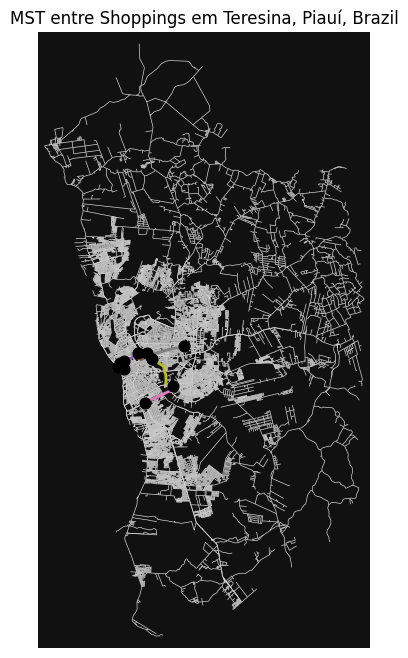

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
city_to_plot = "Teresina, Piauí, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module an

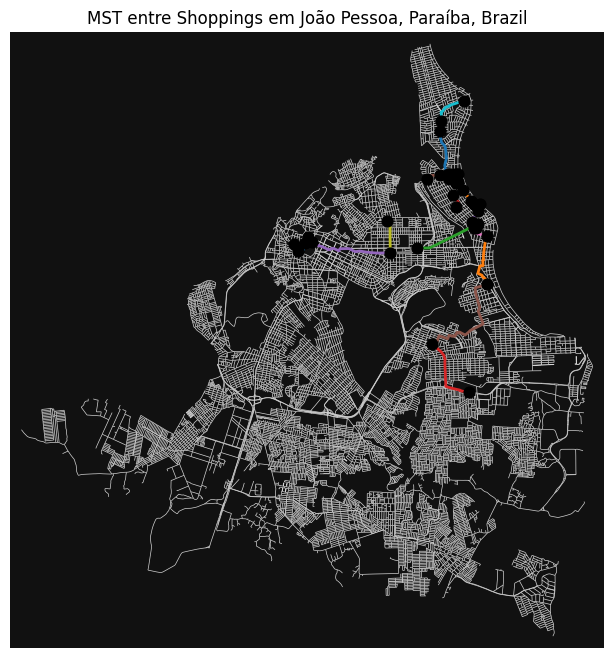

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:
city_to_plot = "João Pessoa, Paraíba, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module an

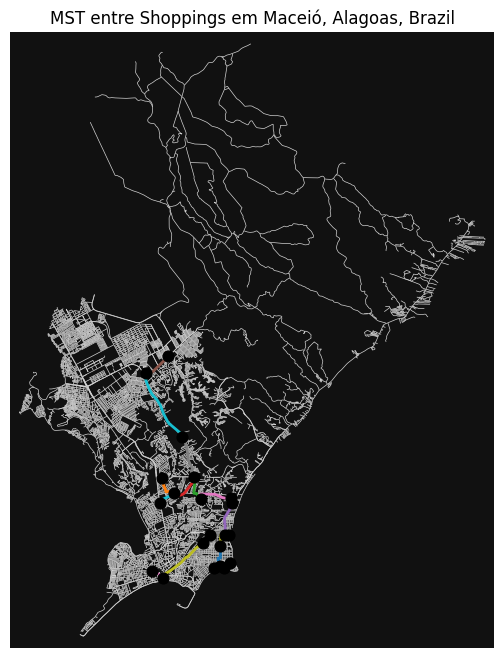

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:
city_to_plot = "Maceió, Alagoas, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

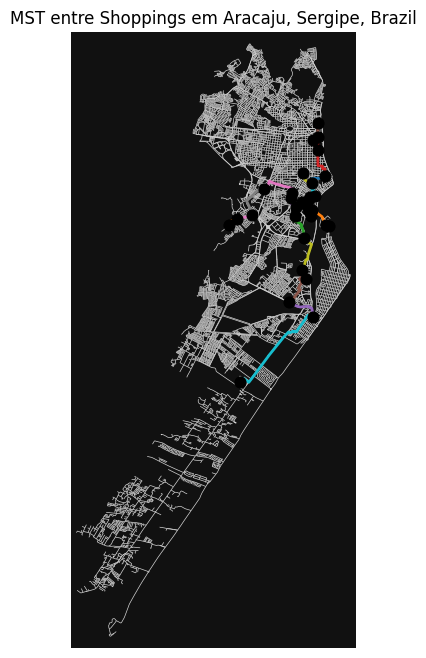

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
city_to_plot = "Aracaju, Sergipe, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for r

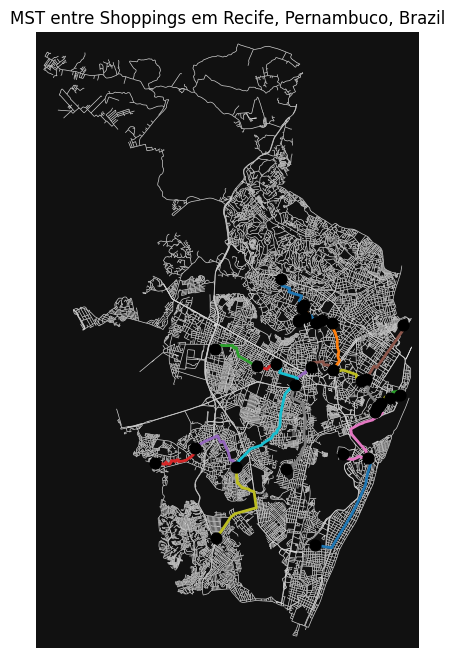

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
city_to_plot = "Recife, Pernambuco, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for r

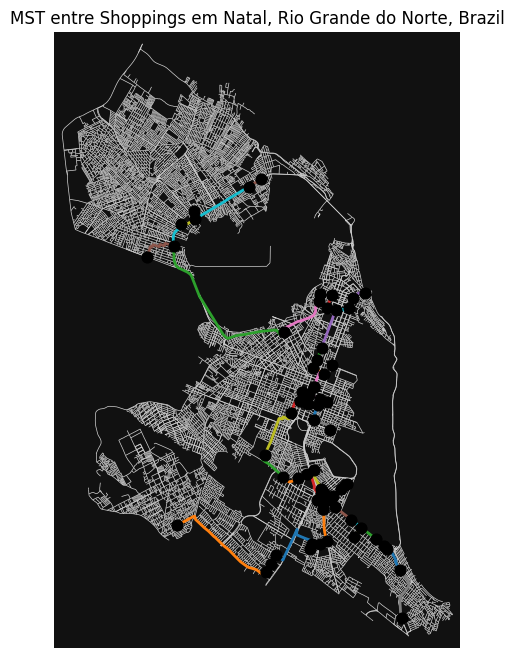

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
city_to_plot = "Natal, Rio Grande do Norte, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

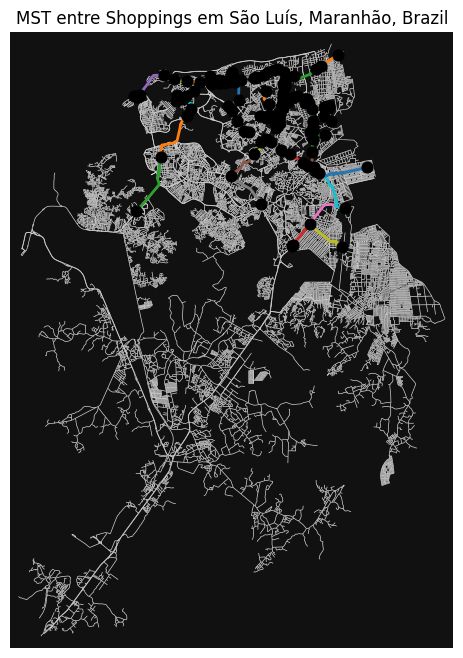

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
city_to_plot = "São Luís, Maranhão, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for r

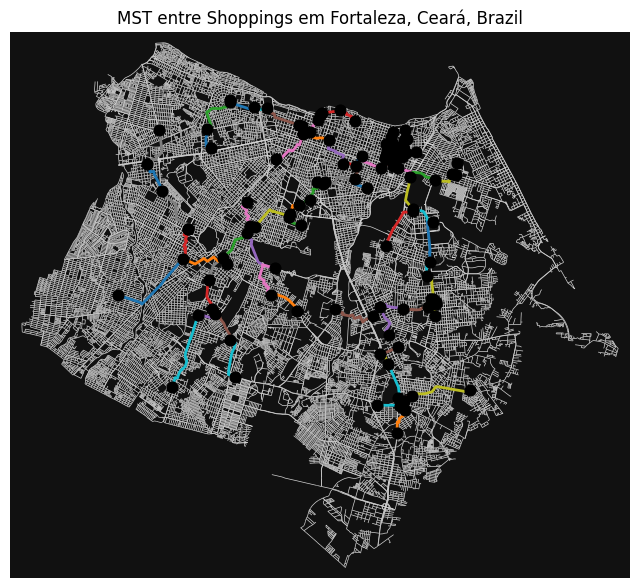

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
city_to_plot = "Fortaleza, Ceará, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3848556257.py:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module an

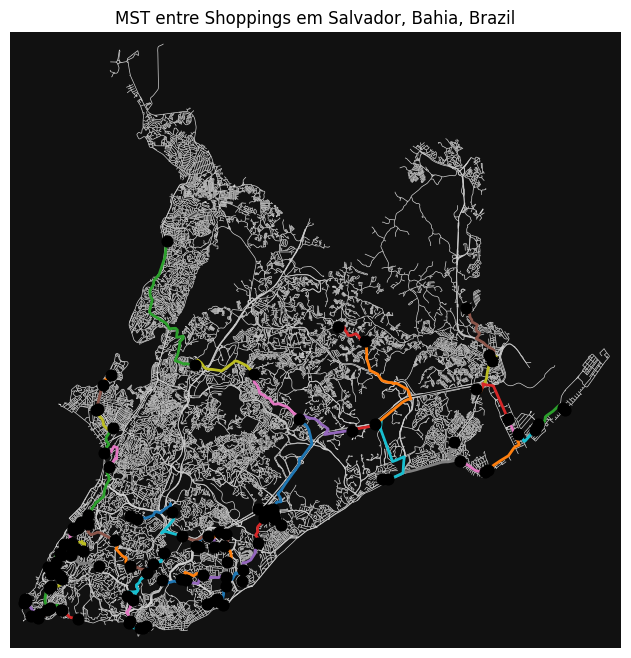

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
city_to_plot = "Salvador, Bahia, Brazil"
_ = run_city_pipeline(city_to_plot, plot=True)


**Comentário dos blocos acima:**  
Gera o **mapa final** para a cidade escolhida, desenhando a malha viária, **todos os shoppings** e as **rotas** da **MST**.
